## UDP Traceroute Connectivity by Probe

This notebook uses _existing_ RIPE Atlas measurements to determine how many RIPE Atlas probes might have issues with UDP connectivity. The basic methodology is as follows:

- Examine measurement metadata to find UDP traceroutes from many probes, over time (currently measurements ending in 2015, or still ongoing).
- Take latency to target and target reachability information from each sample. For samples where the target is not reached but some hops did respond, take the latest hop.
- Group reachability information by probe, and classify probes by how confident we are UDP is broken on them.

This notebook searches the RIPE atlas measurement metadata archive (available from [ftp.ripe.net](ftp://ftp.ripe.net/atlas/measurements)) for UDP and TCP traceroute measurements, and uses the Atlas API to download measurements and cache them locally.

### Preamble

Set up the environment and define functions we'll use later.

In [62]:
# Some jupyter magic to set up the environment correctly
%load_ext autoreload
%autoreload 2
%matplotlib inline

# thanks for letting me know about your plans but i don't really care
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

# things we need, things to make us go
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import collections
import warnings
import hashlib
import requests
import os.path
import time
import calendar
import itertools
import json

##############################################################################
# Trace metadata named tuple,
# and generator for extracting these from the all-measurements-fjson.txt file.
##############################################################################

TraceMeta = collections.namedtuple("TraceMeta", 
                ("msm_id", "af", "proto", "target", 
                 "start_epoch", "stop_epoch", "interval", "probes"))

def tm_generator(first_start=0, last_start=calendar.timegm(time.gmtime()), skip_lines = 0):
    current_time = calendar.timegm(time.gmtime())
    
    with open("data_cache/all-measurements-fjson.txt") as fjf:
        for num, line in enumerate(fjf):
            if num < skip_lines:
                continue
            
            mm = json.loads(line)
                
            if (((mm['type']['id'] == 2) or (mm['type']['id'] == 4)) and
                ((mm['status']['id'] == 2) or (mm['status']['id'] == 4)) and
                (('protocol' in mm) or ('proto_tcp' in mm)) and
                (mm['start_time'] >= first_start) and
                (mm['start_time'] < last_start) ):
            
                    if mm['status']['id'] == 4:
                        stop_time = mm['stop_time']
                    else:
                        stop_time = current_time
                    
                    if 'proto_tcp' in mm and mm['proto_tcp']:
                        proto = 'TCP'
                    else:
                        proto = mm['protocol']
                        
                    yield TraceMeta(mm['msm_id'], mm['af'], proto, mm['dst_addr'], 
                                    mm['start_time'], stop_time, mm['interval'],
                                    mm['participant_count'])

##############################################################################
# MSM retrieval code
##############################################################################

def get_msm(msm_id, gen, cachedir=None, start=None, stop=None):
    """
    Given an MSM, fetch it from the cache or from the RIPE Atlas API.
    Yield each separate result according to the generation function.
    """
    url = "https://atlas.ripe.net/api/v1/measurement/%u/result/" % (msm_id,)

    params = {"format": "json"}
    if start is not None and stop is not None:
        params["start"] = str(start)
        params["stop"] = str(stop)
    
    if cachedir and os.path.isdir(cachedir):
        filepath = os.path.join(cachedir, "measurement", "%u.json" % (msm_id,))

        # download if not present
        if not os.path.isfile(filepath):
            with open(filepath, mode="wb") as file:
                print("Cache miss, retrieving "+url)
                res = requests.get(url, params=params)

                if not res.ok:
                    raise "Atlas measurement API request failed: "+repr(res.json())
                
                file.write(res.content)

        # then read from cache
        with open(filepath) as stream:
            yield from gen(json.loads(stream.read()))

    else:
        # just read from the net
        res = requests.get(url, params=params)
        yield from gen(json.loads(res.content.decode("utf-8")))

##############################################################################
# Connectivity sample named tuple,
# connectivity sample generator for use with get_msm(),
# and dataframe creation function wrapping all of this together
##############################################################################

TCSample = collections.namedtuple("TCSample",
                     ("msm_id","time","af","proto","pid","sip","dip","reached","hop","rtt"))

def gen_tcs(msm_ary):
    for a_res in msm_ary:        
        if a_res['type'] == 'traceroute':
            if ('result' in a_res):
                maxhop = 0
                maxhop_ok = False
                for hop in a_res['result']:
                    if 'result' in hop:
                        for pkt in hop['result']:
                            if 'from' in pkt:
                                maxhop = hop['hop']
                                if pkt['from'] == a_res['dst_addr']:
                                    maxhop_ok = True
                                    if 'rtt' in pkt:
                                        rtt = pkt['rtt']
                                    else:
                                        rtt = -1
                                    yield TCSample(a_res['msm_id'],
                                           int(a_res['timestamp']), a_res['af'], a_res['proto'],
                                           a_res['prb_id'], a_res['src_addr'], a_res['dst_addr'],
                                           True, maxhop, rtt)
                                    break
                if not maxhop_ok:
                    try:
                        yield TCSample(a_res['msm_id'],
                                       int(a_res['timestamp']), a_res['af'], a_res['proto'],
                                       a_res['prb_id'], a_res['src_addr'], a_res['dst_addr'],
                                       False, maxhop, -1)
                    except KeyError:
                        # ignore completely broken results
                        pass

def tcsample_dataframe(msm_ids, cachedir=None, start=None, stop=None, chunksize=1000000):
    """
    Given an iterable of MSMs, create a dataframe of trace connectivity samples.
    """
    
    # initialize accumulators
    adf = pd.DataFrame([], columns=TCSample._fields)
    data = []
    
    # get individual rows from get_msm
    for msm_id in msm_ids:
        for tcs in get_msm(msm_id, gen=gen_tcs, 
                           start=start, stop=stop, 
                           cachedir=cachedir):
            data.append(tcs)
            
            # Append dataframe to dataframe accumulator if chunking.
            if len(data) >= chunksize:
                adf = adf.append(pd.DataFrame(data, columns=TCSample._fields), ignore_index=True)
                data = []
                
    # Append final dataframe if non-empty.
    if len(data) > 0:
        adf = adf.append(pd.DataFrame(data, columns=TCSample._fields), ignore_index=True)

    # Counter column for aggregation
    adf['n'] = 1
    
    return adf

##############################################################################
# Plotting utility function
##############################################################################

def plot_ecdf(a, **kwargs):
    sa = np.sort(a)
    yv = np.arange(len(sa))/float(len(sa))
    plt.plot(sa, yv, **kwargs)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Step 1: find MSM ids for UDP traceroutes 

Here we limit ourselves to MSMs run (1) from many probes, to maximize the number of probes we'll see samples from, and (2) ending in 2015 or later, to focus on the recent past. Note that many of these are MSMs we specified ourselves for our TMA paper. Not many people seem to be interested in UDP traceroute.

In [3]:
# get ALL the traceroutes! (takes about five minutes on Forclaz)
tmgen = tm_generator()
%time tmdf = pd.DataFrame([m for m in tmgen], columns=TraceMeta._fields)
tmgen.close() # generator wraps a file, close it.

# estimate sample count
tmdf['samples'] = (tmdf['probes'] * (tmdf['stop_epoch'] - tmdf['start_epoch'])) / tmdf['interval']

# cast timestamps
tmdf['start'] = pd.to_datetime(tmdf['start_epoch'] * 1e9)
tmdf['stop'] = pd.to_datetime(tmdf['stop_epoch'] * 1e9)
tmdf['duration'] = tmdf['stop'] - tmdf['start']

# count msms
tmdf['n'] = 1

# index by msm
tmdf.index = pd.Index(tmdf['msm_id'])
del(tmdf['msm_id'])

# exclude all measurements ending before 1 Jan 2015, and split by protocol
tmdf_udp = tmdf[tmdf['proto'] == 'UDP']
tmdf_udp = tmdf_udp[tmdf_udp["stop"] >= "2015-01-01"]
tmdf_tcp = tmdf[tmdf['proto'] == 'TCP']
tmdf_tcp = tmdf_tcp[tmdf_tcp["stop"] >= "2015-01-01"]
tmdf_icmp = tmdf[tmdf['proto'] == 'TCP']
tmdf_icmp = tmdf_icmp[tmdf_icmp["stop"] >= "2015-01-01"]

# find appropriate MSMs
msm_ids = tmdf_udp[tmdf_udp['probes'] >= 64].index.values

CPU times: user 5min 2s, sys: 7.56 s, total: 5min 10s
Wall time: 5min 10s


In [6]:
len(msm_ids)

8436

### Step 2: Retrieve MSMs and parse them into a dataframe

In [69]:
%time tcsdf = tcsample_dataframe(msm_ids, cachedir="data_cache", chunksize=100000)

Cache miss, retrieving https://atlas.ripe.net/api/v1/measurement/1873609/result/
Cache miss, retrieving https://atlas.ripe.net/api/v1/measurement/1873637/result/
Cache miss, retrieving https://atlas.ripe.net/api/v1/measurement/1873652/result/
Cache miss, retrieving https://atlas.ripe.net/api/v1/measurement/1873689/result/
Cache miss, retrieving https://atlas.ripe.net/api/v1/measurement/1873690/result/
Cache miss, retrieving https://atlas.ripe.net/api/v1/measurement/1873693/result/
Cache miss, retrieving https://atlas.ripe.net/api/v1/measurement/1873694/result/
Cache miss, retrieving https://atlas.ripe.net/api/v1/measurement/1873850/result/
Cache miss, retrieving https://atlas.ripe.net/api/v1/measurement/1874040/result/
Cache miss, retrieving https://atlas.ripe.net/api/v1/measurement/1874198/result/
Cache miss, retrieving https://atlas.ripe.net/api/v1/measurement/1874464/result/
Cache miss, retrieving https://atlas.ripe.net/api/v1/measurement/1874700/result/
Cache miss, retrieving https

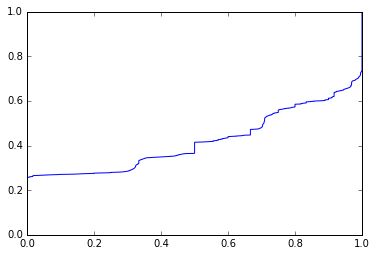

In [70]:
plot_ecdf(tcsdf.groupby('pid').reached.sum() / tcsdf.groupby('pid').n.sum())

(0, 32)

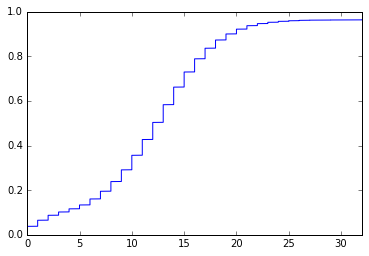

In [81]:
plot_ecdf(tcsdf[np.logical_not(tcsdf['reached'])]['hop'])
plt.xlim(0,32)

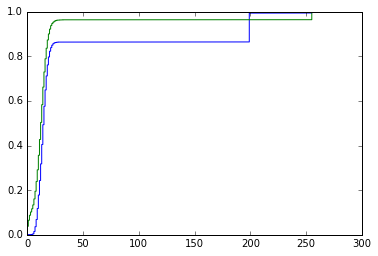

In [87]:
plot_ecdf(tcsdf[tcsdf['reached']]['hop'])
plot_ecdf(tcsdf[np.logical_not(tcsdf['reached'])]['hop'])

Next up: start pruning back rows that don't answer our question:

- all msms where no traceroute reached the target
- all probes with less than n attempts

Then classify probes: definitely works, definitely broken, etc. For broken probes, look at where the brokenness happens. 

# Scratch code

Sandbox, dirtpile, etc

In [88]:
tcsdf

,msm_id,time,af,proto,pid,sip,dip,reached,hop,rtt,n
0,1839092,1421433434,4,UDP,1000,192.168.10.9,199.19.3.1,True,17,137.211,1
1,1839092,1421433435,4,UDP,1001,10.0.0.131,199.19.3.1,True,11,150.322,1
2,1839092,1421433434,4,UDP,1002,192.168.103.22,199.19.3.1,True,11,164.393,1
3,1839092,1421433435,4,UDP,1009,192.168.178.22,199.19.3.1,True,10,170.409,1
4,1839092,1421433435,4,UDP,1031,192.168.0.4,199.19.3.1,False,3,-1.000,1
5,1839092,1421433434,4,UDP,1035,192.168.1.10,199.19.3.1,True,13,198.966,1
6,1839092,1421433433,4,UDP,1036,113.197.10.84,199.19.3.1,True,20,230.613,1
7,1839092,1421433435,4,UDP,1041,172.16.127.7,199.19.3.1,True,16,182.540,1
8,1839092,1421433435,4,UDP,1044,10.0.0.101,199.19.3.1,True,11,171.021,1
9,1839092,1421433434,4,UDP,1051,192.168.0.3,199.19.3.1,True,14,184.106,1


In [91]:
tcsdf.groupby('msm_id')['reached'].sum()

msm_id
1839092      89
1842149    2328
1873371       0
1873380       0
1873381       0
1873571       0
1873575       0
1873577       0
1873582       0
1873590       0
1873591       0
1873593       0
1873598       0
1873604       0
1873606       0
1873609       0
1873637       0
1873652       0
1873689       0
1873690       0
1873693       0
1873694       0
1873850       0
1874040       0
1874198       0
1874464       0
1874700       0
1874778       0
1874781       0
1874783       0
           ... 
2898597    2149
2898599    2002
2898601    2177
2898603    2016
2898605    2173
2898607    1968
2898609    2152
2898611    1925
2898613    2175
2898615    1986
2898617    2173
2898619    1964
2898621    2168
2898623    1968
2898625    2157
2898627    1920
2898629    2146
2898631    1904
2928247       0
2928248      11
2944401       7
2944630     112
2944707     102
2944909     102
2946022     128
2966296       6
2971614       5
3020847      90
3021090     145
3102318       0
Name: reached, dt